In [19]:
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn


# Hàm để load ảnh và vẽ keypoints lên
def plot_keypoints(image_path, pts_file):
    # Đọc ảnh
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển thành RGB cho phù hợp với Matplotlib

    # Đọc keypoints
    keypoints = read_keypoints(pts_file)

    # Hiển thị ảnh và các keypoints
    plt.imshow(img)
    for (x, y) in keypoints:
        plt.scatter([x], [y], c='red', s=10)
    
    plt.show()


In [20]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import dlib

class FaceLandmarkDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.detector = dlib.get_frontal_face_detector()

        if len(self.image_files) == 0:
            raise ValueError(f"Không có ảnh .jpg nào trong thư mục {image_dir}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        pts_file = image_file.replace('.jpg', '.pts')
        
        image_path = os.path.join(self.image_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Không thể đọc ảnh từ {image_path}. Đảm bảo rằng đường dẫn là chính xác và file tồn tại.")
        
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        pts_path = os.path.join(self.image_dir, pts_file)
        landmarks = self.read_pts(pts_path)
        if landmarks is None:
            raise ValueError(f"Không thể đọc keypoints từ {pts_path}. Đảm bảo rằng file tồn tại và định dạng đúng.")
        
        landmarks = torch.tensor(landmarks, dtype=torch.float32)

        dets = self.detector(image_rgb, 1)
        if len(dets) == 0:
            raise ValueError(f"Không tìm thấy khuôn mặt trong ảnh {image_file}")
        
        face = dets[0]
        bbox = (face.left(), face.top(), face.right(), face.bottom())

        # Tăng kích thước bounding box lên 1.5 lần
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        center_x = (bbox[0] + bbox[2]) // 2
        center_y = (bbox[1] + bbox[3]) // 2

        new_width = int(width * 1.2)
        new_height = int(height * 1.2)

        new_x1 = max(center_x - new_width // 2, 0)
        new_y1 = max(center_y - new_height // 2, 0)
        new_x2 = min(center_x + new_width // 2, image_rgb.shape[1] - 1)
        new_y2 = min(center_y + new_height // 2, image_rgb.shape[0] - 1)

        # Cắt ảnh theo bounding box mới
        crop_image = image_rgb[new_y1:new_y2, new_x1:new_x2]

        # Resize ảnh về kích thước 224x224
        crop_image = cv2.resize(crop_image, (224, 224))

        # Resize landmarks tương ứng với kích thước ảnh crop
        cropped_landmarks = landmarks.clone()
        cropped_landmarks[:, 0] = (landmarks[:, 0] - new_x1) * (224 / (new_x2 - new_x1))
        cropped_landmarks[:, 1] = (landmarks[:, 1] - new_y1) * (224 / (new_y2 - new_y1))

        # Đảm bảo các giá trị tọa độ nằm trong phạm vi hợp lệ
        cropped_landmarks = torch.clamp(cropped_landmarks, min=0, max=223)

        if self.transform:
            transformed = self.transform(image=crop_image, landmarks=cropped_landmarks, bbox=(new_x1, new_y1, new_x2, new_y2))
            crop_image = transformed['image']
            cropped_landmarks = transformed['landmarks']
            bbox = transformed['bbox']
        else:
            crop_image = torch.from_numpy(crop_image).permute(2, 0, 1).float() / 255.0

        return crop_image, cropped_landmarks, (new_x1, new_y1, new_x2, new_y2)

    def read_pts(self, pts_file):
        keypoints = []
        if not os.path.isfile(pts_file):
            raise FileNotFoundError(f"File .pts không tồn tại: {pts_file}")
        try:
            with open(pts_file, 'r') as f:
                lines = f.readlines()[3:-1]
                for line in lines:
                    x, y = map(float, line.strip().split())
                    keypoints.append((x, y))
        except Exception as e:
            raise ValueError(f"Lỗi khi đọc file {pts_file}: {str(e)}")
        return keypoints

# Ví dụ sử dụng
dataset = FaceLandmarkDataset(image_dir="D:\lmvh\lmvh-proj-filter\src\data\helen_no_mirror")
crop_image, cropped_landmarks, bbox = dataset[0]

print(crop_image.shape)       # Tensor của ảnh đã cắt: (C, H, W)
print(cropped_landmarks.shape)   # Tensor của landmarks: (68, 2)
print(bbox)                    # Bound


torch.Size([3, 224, 224])
torch.Size([68, 2])
(485, 424, 1151, 1090)


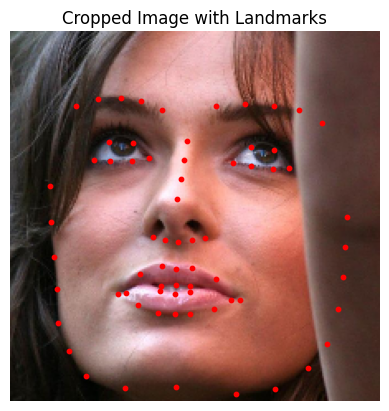

In [21]:
import matplotlib.pyplot as plt

# Lấy ảnh, landmarks, và bounding box từ dataset
crop_image, cropped_landmarks, bbox = dataset[20]

# Chuyển đổi tensor về dạng numpy để hiển thị
crop_image_np = crop_image.permute(1, 2, 0).numpy()  # Chuyển từ (C, H, W) sang (H, W, C)

# Vẽ ảnh
plt.imshow(crop_image_np)
plt.scatter(cropped_landmarks[:, 0].numpy(), cropped_landmarks[:, 1].numpy(), c='red', s=10)  # Vẽ các điểm landmark
plt.title("Cropped Image with Landmarks")
plt.axis('off')  # Tắt trục
plt.show()


In [22]:
import torch
import torch.nn as nn
import torchvision.models as models

class LandmarkModel(nn.Module):
    def __init__(self):
        super(LandmarkModel, self).__init__()
        # Sử dụng ResNet18 làm backbone
        self.resnet = models.resnet18(pretrained=True)
        
        # Thay đổi output layer để dự đoán 68 điểm (x, y)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 68 * 2)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Khởi tạo mô hình
model = LandmarkModel()


C:\Users\firek\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\firek\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
from torch.utils.data import DataLoader

# Khởi tạo dataset
dataset = FaceLandmarkDataset(image_dir='D:\lmvh\lmvh-proj-filter\src\data\helen_no_mirror')

# Tạo DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [24]:
import torch.optim as optim
from tqdm import tqdm

# Định nghĩa hàm loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Huấn luyện mô hình
num_epochs = 10  # Số epoch bạn muốn huấn luyện
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    # Sử dụng tqdm để hiển thị tiến trình
    with tqdm(train_loader, unit='batch') as tepoch:
        tepoch.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
        
        for images, landmarks, _ in tepoch:
            optimizer.zero_grad()

            # Dự đoán đầu ra từ mô hình
            outputs = model(images)

            # Reshape output để so sánh với landmarks
            outputs = outputs.view(-1, 68, 2)
            loss = criterion(outputs, landmarks.view(-1, 68, 2))

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())  # Cập nhật thông tin loss

    # In ra trung bình loss của epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader):.4f}')


Epoch [1/10]:   2%|▏         | 1/63 [02:54<3:00:12, 174.40s/batch, loss=1.7e+4]


ValueError: Không tìm thấy khuôn mặt trong ảnh 23739520_1.jpg

In [ ]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Lấy một ví dụ từ dataset
with torch.no_grad():
    test_image, test_landmarks, _ = dataset[0]  # Lấy ví dụ đầu tiên
    test_image = test_image.unsqueeze(0)  # Thêm batch dimension
    predictions = model(test_image)

    # Reshape predictions
    predictions = predictions.view(-1, 68, 2)

print(predictions.shape)  # Kiểm tra kích thước của output
